# Inspired Project: Audio Contrastive Learning with Self-Supervision

**Inspired by DS4440 Homework 3 - But Applied to a Different Modality**

While the homework focused on **image contrastive learning (SimCLR)**, this project explores **audio contrastive learning** - applying the same principles to a fundamentally different data modality.

## Key Differences from Homework 3:

| Aspect | Homework 3 | This Project |
|--------|-----------|--------------|
| **Data Modality** | Images (2D) | Audio (1D waveforms / 2D spectrograms) |
| **Dataset** | CIFAR-10 (images) | Speech Commands / Environmental Sounds (audio) |
| **Augmentations** | Crop, flip, color jitter, blur | Time stretch, pitch shift, noise, time/freq masking |
| **Encoder Architecture** | ResNet (2D CNN) | 1D CNN or Transformer (for audio) |
| **Input Format** | RGB images (3×32×32) | Waveforms (1×16000) or Spectrograms (freq×time) |
| **Evaluation Tasks** | Image classification | Audio classification, speaker recognition |
| **Domain** | Computer vision | Audio/speech processing |

## Project Goals:
1. Implement contrastive learning for audio data
2. Build audio-specific data augmentation pipeline
3. Design audio encoder architectures (1D CNN/Transformer)
4. Train self-supervised audio representations
5. Evaluate with linear probing on audio classification tasks


## 1. Setup and Configuration


In [1]:
!pip install torchcodec

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Optional
from dataclasses import dataclass
import warnings
from datasets import load_dataset
import torchcodec
warnings.filterwarnings('ignore')

# Audio processing libraries
try:
    import librosa
    import soundfile as sf
    HAS_AUDIO = True
except:
    HAS_AUDIO = False
    print("librosa/soundfile not available - using synthetic audio")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


In [3]:
@dataclass
class AudioContrastiveConfig:
    # Audio parameters
    sample_rate: int = 16000  # Hz
    duration: float = 1.0  # seconds
    n_mels: int = 80  # Mel spectrogram bins
    n_fft: int = 512
    hop_length: int = 256

    # Model
    encoder_type: str = "1d_cnn" # "transformer" # or "1d_cnn"
    proj_dim: int = 128  # Projection head dimension

    # Training
    batch_size: int = 32
    learning_rate: float = 3e-4
    num_epochs: int = 50
    temperature: float = 0.5

    # Augmentation
    time_stretch_range: Tuple[float, float] = (0.8, 1.2)
    pitch_shift_range: Tuple[int, int] = (-4, 4)  # semitones
    noise_level: float = 0.01
    time_mask_param: int = 10  # frames to mask
    freq_mask_param: int = 8  # mel bins to mask

    # Data
    dataset_name: str = "environmental"  # or , "synthetic"
    num_classes: int = 10

    # Output
    out_dir: str = "./audio_contrastive_results"

    def __post_init__(self):
        Path(self.out_dir).mkdir(parents=True, exist_ok=True)

cfg = AudioContrastiveConfig()


## 2. Audio-Specific Data Augmentations

Unlike image augmentations (crop, flip, color jitter), audio requires different transformations:
- **Time stretching**: Change speed without changing pitch
- **Pitch shifting**: Change pitch without changing speed
- **Noise injection**: Add background noise
- **Time masking**: Mask time frames (like cutout for images)
- **Frequency masking**: Mask frequency bands


In [4]:
class AudioAugmentation:
    """Audio-specific augmentations for contrastive learning"""

    def __init__(self, config: AudioContrastiveConfig):
        self.config = config
        self.sample_rate = config.sample_rate

    def time_stretch(self, audio: np.ndarray, rate: Optional[float] = None) -> np.ndarray:
        """Time stretching: change speed without changing pitch"""
        if rate is None:
            rate = np.random.uniform(*self.config.time_stretch_range)

        if HAS_AUDIO:
            return librosa.effects.time_stretch(audio, rate=rate)
        else:
            # Simple resampling approximation
            indices = np.linspace(0, len(audio), int(len(audio) * rate))
            return np.interp(indices, np.arange(len(audio)), audio)

    def pitch_shift(self, audio: np.ndarray, n_steps: Optional[int] = None) -> np.ndarray:
        """Pitch shifting: change pitch without changing speed"""
        if n_steps is None:
            n_steps = np.random.randint(*self.config.pitch_shift_range)

        if HAS_AUDIO:
            return librosa.effects.pitch_shift(audio, sr=self.sample_rate, n_steps=n_steps)
        else:
            # Simple approximation: frequency shift
            return audio  # Placeholder

    def add_noise(self, audio: np.ndarray, noise_level: Optional[float] = None) -> np.ndarray:
        """Add Gaussian noise"""
        if noise_level is None:
            noise_level = self.config.noise_level

        noise = np.random.normal(0, noise_level, len(audio))
        return audio + noise

    def time_mask(self, spectrogram: np.ndarray, param: Optional[int] = None) -> np.ndarray:
        """Mask time frames """
        if param is None:
            param = self.config.time_mask_param

        spec = spectrogram.copy()
        t_len = spec.shape[1]

        t0 = np.random.randint(0, max(1, t_len - param))
        spec[:, t0:t0+param] = 0
        return spec

    def freq_mask(self, spectrogram: np.ndarray, param: Optional[int] = None) -> np.ndarray:
        """Mask frequency bands"""
        if param is None:
            param = self.config.freq_mask_param

        spec = spectrogram.copy()
        f_len = spec.shape[0]

        f0 = np.random.randint(0, max(1, f_len - param))
        spec[f0:f0+param, :] = 0
        return spec

    def apply_random_augmentations(self, audio: np.ndarray) -> np.ndarray:
        """Apply random combination of augmentations"""
        # Time stretch
        if np.random.rand() > 0.5:
            audio = self.time_stretch(audio)

        # Pitch shift
        if np.random.rand() > 0.5:
            audio = self.pitch_shift(audio)

        # Add noise
        if np.random.rand() > 0.5:
            audio = self.add_noise(audio)

        return audio

    def apply_spectrogram_augmentations(self, spectrogram: np.ndarray) -> np.ndarray:
        """Apply augmentations to spectrogram"""
        spec = spectrogram.copy()

        # Time masking
        if np.random.rand() > 0.5:
            spec = self.time_mask(spec)

        # Frequency masking
        if np.random.rand() > 0.5:
            spec = self.freq_mask(spec)

        return spec

print("Audio augmentation pipeline ready!")


Audio augmentation pipeline ready!


## 3. Audio Data Loading and Preprocessing

Load audio datasets and convert to spectrograms (similar to how images are processed).


In [5]:
def audio_to_spectrogram(audio: np.ndarray, config: AudioContrastiveConfig) -> np.ndarray:
    """Convert audio waveform to mel spectrogram"""
    if HAS_AUDIO:
        spec = librosa.feature.melspectrogram(
            y=audio,
            sr=config.sample_rate,
            n_mels=config.n_mels,
            n_fft=config.n_fft,
            hop_length=config.hop_length
        )
        # Convert to log scale (dB)
        spec = librosa.power_to_db(spec, ref=np.max)
    else:
        # Synthetic spectrogram for demo
        n_frames = len(audio) // config.hop_length
        spec = np.random.randn(config.n_mels, n_frames)

    return spec

def load_audio_dataset(source="environmental", n_samples=1000, config=None):
    """ Load audio dataset. """
    if config is None:
        config = AudioContrastiveConfig()

    if source == "synthetic":
        print("Generating synthetic audio dataset...")

        # Generate synthetic audio waveforms (sine waves with different frequencies)
        dataset = []
        n_samples_per_class = n_samples // config.num_classes

        for class_id in range(config.num_classes):
            for _ in range(n_samples_per_class):
                # Generate synthetic audio (sine wave with class-specific frequency)
                duration_samples = int(config.sample_rate * config.duration)
                freq = 200 + class_id * 100  # Different frequency per class
                t = np.linspace(0, config.duration, duration_samples)
                audio = np.sin(2 * np.pi * freq * t)

                # Add some variation
                audio += 0.1 * np.random.randn(len(audio))

                # Convert to spectrogram
                spec = audio_to_spectrogram(audio, config)

                dataset.append({
                    'audio': audio,
                    'spectrogram': spec,
                    'label': class_id
                })

        return dataset

    elif source == "environmental":
        print("Loading environmental sounds dataset...")

        esc50 = load_dataset("ashraq/esc50", split="train")

        # ESC-50 has 50 classes labeled 0–49
        assert config.num_classes <= 50, "ESC-50 supports up to 50 classes"

        samples_per_class = n_samples // config.num_classes
        target_len = int(config.sample_rate * config.duration)

        dataset = []
        class_counts = {i: 0 for i in range(config.num_classes)}

        for item in esc50:
            label = item["target"]

            # Skip unused classes
            if label >= config.num_classes:
                continue

            if class_counts[label] >= samples_per_class:
                continue

            # Load audio
            audio = np.array(item["audio"]["array"], dtype=np.float32)
            orig_sr = item["audio"]["sampling_rate"]

            # Resample if needed
            if orig_sr != config.sample_rate:
                audio = librosa.resample(
                    audio,
                    orig_sr=orig_sr,
                    target_sr=config.sample_rate
                )

            # Trim or pad to fixed duration
            if len(audio) > target_len:
                audio = audio[:target_len]
            else:
                audio = np.pad(audio, (0, target_len - len(audio)))

            # Convert to spectrogram
            spec = audio_to_spectrogram(audio, config)

            dataset.append({
                "audio": audio,
                "spectrogram": spec,
                "label": label
            })

            class_counts[label] += 1

            # Stop early if done
            if sum(class_counts.values()) >= n_samples:
                break

        return dataset

# Load dataset
audio_dataset = load_audio_dataset("environmental", n_samples=500, config=cfg)
print(f"Loaded {len(audio_dataset)} audio samples")
print(f"Sample shape: {audio_dataset[0]['spectrogram'].shape}")


Loading environmental sounds dataset...


Repo card metadata block was not found. Setting CardData to empty.


Loaded 400 audio samples
Sample shape: (80, 63)


In [6]:
def nt_xent_loss_audio(z1: torch.Tensor, z2: torch.Tensor, tau: float = 0.5) -> torch.Tensor:
    """
    NT-Xent (Normalized Temperature-scaled Cross Entropy) loss for audio.
    Same formulation as SimCLR but works with audio embeddings.

    Args:
        z1, z2: tensors of shape (N, D) representing two augmented views of N audio samples
        tau: temperature parameter

    Returns:
        scalar loss value
    """
    N = z1.shape[0]

    # Normalize embeddings
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Concatenate both views: (2N, D)
    z = torch.cat([z1, z2], dim=0)

    # Compute cosine similarity matrix: (2N, 2N)
    sim_matrix = torch.mm(z, z.T) / tau

    # Mask self-similarity (diagonal)
    mask = torch.eye(2 * N, dtype=torch.bool, device=z.device)
    sim_matrix = sim_matrix.masked_fill(mask, -9e15)

    # Identify positive pairs
    # For samples 0 to N-1, positives are at N to 2N-1
    # For samples N to 2N-1, positives are at 0 to N-1
    pos_indices = torch.cat([
        torch.arange(N, 2 * N, device=z.device),
        torch.arange(0, N, device=z.device)
    ], dim=0)

    # Compute loss using log-softmax for numerical stability
    log_prob = sim_matrix - torch.logsumexp(sim_matrix, dim=1, keepdim=True)
    pos_log_prob = log_prob[torch.arange(2 * N, device=z.device), pos_indices]

    loss = -pos_log_prob.mean()
    return loss

# Sanity check
N, D = 4, 128
z1 = torch.randn(N, D)
z2 = torch.randn(N, D)
loss = nt_xent_loss_audio(z1, z2)
print(f"Sample loss: {loss.item():.4f}")
print("Contrastive loss ready!")


Sample loss: 1.9367
Contrastive loss ready!


## 5. Audio Encoder Architectures

Unlike ResNet for images, we need architectures suitable for audio:
- **1D CNN**: Process waveforms or spectrograms
- **Transformer**: Process spectrogram patches


In [7]:
class AudioEncoder1DCNN(nn.Module):
    """1D CNN encoder for audio waveforms or spectrograms"""

    def __init__(self, input_dim=1, proj_dim=128):
        super().__init__()

        # 1D CNN layers for audio processing
        self.encoder = nn.Sequential(
            # First block
            nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),

            # Second block
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            # Third block
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            # Fourth block
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            # Global average pooling
            nn.AdaptiveAvgPool1d(1)
        )

        # Projection head (same as SimCLR)
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, proj_dim)
        )

    def forward(self, x):
        # x: (B, C, T) where C=1 for waveform, C=n_mels for spectrogram
        h = self.encoder(x)  # (B, 512, 1)
        h = h.squeeze(-1)  # (B, 512)
        z = self.projector(h)  # (B, proj_dim)
        return h, z


class AudioEncoderTransformer(nn.Module):
    """Transformer encoder for audio spectrograms"""

    def __init__(self, n_mels=80, d_model=256, nhead=8, num_layers=4, proj_dim=128):
        super().__init__()
        self.d_model = d_model

        # Patch embedding (treat time frames as patches)
        self.patch_embed = nn.Linear(n_mels, d_model)

        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1000, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Global pooling
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Projection head
        self.projector = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, proj_dim)
        )

    def forward(self, x):
        # x: (B, n_mels, T) spectrogram
        B, n_mels, T = x.shape

        # Transpose to (B, T, n_mels) and embed
        x = x.transpose(1, 2)  # (B, T, n_mels)
        x = self.patch_embed(x)  # (B, T, d_model)

        # Add positional encoding
        pos = self.pos_encoding[:T].unsqueeze(0)
        x = x + pos

        # Transformer encoding
        x = self.transformer(x)  # (B, T, d_model)

        # Global average pooling
        x = x.transpose(1, 2)  # (B, d_model, T)
        h = self.pool(x).squeeze(-1)  # (B, d_model)

        # Projection
        z = self.projector(h)  # (B, proj_dim)
        return h, z


class AudioContrastiveModel(nn.Module):
    """Complete model: Encoder + Projection Head (like SimCLR)"""

    def __init__(self, config: AudioContrastiveConfig):
        super().__init__()
        self.config = config

        if config.encoder_type == "1d_cnn":
            self.encoder = AudioEncoder1DCNN(input_dim=1, proj_dim=config.proj_dim)
        elif config.encoder_type == "transformer":
            self.encoder = AudioEncoderTransformer(
                n_mels=config.n_mels,
                proj_dim=config.proj_dim
            )
        else:
            raise ValueError(f"Unknown encoder type: {config.encoder_type}")

    def forward(self, x):
        """Forward pass: returns both features and projections"""
        return self.encoder(x)

# Test model
model = AudioContrastiveModel(cfg).to(device)
print(f"Model: {cfg.encoder_type}")
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# Test forward pass
if cfg.encoder_type == "1d_cnn":
  test_input = torch.randn(2, 1, 16000).to(device)  # (B, C, T)
else:
  test_input = torch.randn(2, 80, 100).to(device)  # (B, C, T)
h, z = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Feature shape: {h.shape}, Projection shape: {z.shape}")


Model: 1d_cnn
Parameters: 0.86M
Input shape: torch.Size([2, 1, 16000])
Feature shape: torch.Size([2, 512]), Projection shape: torch.Size([2, 128])


In [8]:
class TwoViewsAudioTransform:
    """Create two random augmented views of the same audio sample"""

    def __init__(self, config: AudioContrastiveConfig):
        self.config = config
        self.augmenter = AudioAugmentation(config)

    def __call__(self, audio: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Apply two independent augmentations to the same audio.
        Returns two views as tensors.
        """
        # Apply augmentations independently
        audio1 = self.augmenter.apply_random_augmentations(audio.copy())
        audio2 = self.augmenter.apply_random_augmentations(audio.copy())

        # Convert to spectrograms
        spec1 = audio_to_spectrogram(audio1, self.config)
        spec2 = audio_to_spectrogram(audio2, self.config)

        # Apply spectrogram augmentations
        spec1 = self.augmenter.apply_spectrogram_augmentations(spec1)
        spec2 = self.augmenter.apply_spectrogram_augmentations(spec2)

        # Normalize
        spec1 = (spec1 - spec1.mean()) / (spec1.std() + 1e-8)
        spec2 = (spec2 - spec2.mean()) / (spec2.std() + 1e-8)

        # Convert to tensors
        # For 1D CNN: (1, T) - treat as single channel waveform
        # For transformer: (n_mels, T) - use spectrogram directly
        if self.config.encoder_type == "1d_cnn":
            # Use waveform directly or convert spectrogram to 1D
            view1 = torch.FloatTensor(audio1).unsqueeze(0)  # (1, T)
            view2 = torch.FloatTensor(audio2).unsqueeze(0)  # (1, T)
        else:  # transformer
            view1 = torch.FloatTensor(spec1)  # (n_mels, T)
            view2 = torch.FloatTensor(spec2)  # (n_mels, T)

        return view1, view2

print("Two-view audio transform ready!")


Two-view audio transform ready!


## 7. Self-Supervised Pretraining Loop

Train the audio encoder using contrastive learning (no labels needed!).


In [9]:
def pretrain_audio_contrastive(model, dataset, config, epochs=50):
    """
    Self-supervised pretraining loop for audio contrastive learning.
    Similar to SimCLR but for audio data.
    """
    model = model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    transform = TwoViewsAudioTransform(config)

    # Create data loader
    # For simplicity, we'll process batches manually
    batch_size = config.batch_size
    n_samples = len(dataset)

    print(f"Starting audio contrastive pretraining...")
    print(f"Dataset: {n_samples} samples, Batch size: {batch_size}, Epochs: {epochs}")

    losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        # Shuffle dataset
        indices = np.random.permutation(n_samples)

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_audio = [dataset[idx]['audio'] for idx in batch_indices]

            # Create two views for each sample
            views1, views2 = [], []
            for audio in batch_audio:
                v1, v2 = transform(audio)
                views1.append(v1)
                views2.append(v2)

            # Pad to same length and stack
            max_len = max(v.shape[-1] for v in views1 + views2)
            views1_padded = []
            views2_padded = []

            for v1, v2 in zip(views1, views2):
                # Pad to max_len
                pad1 = max_len - v1.shape[-1]
                pad2 = max_len - v2.shape[-1]
                v1_padded = F.pad(v1, (0, pad1))
                v2_padded = F.pad(v2, (0, pad2))
                views1_padded.append(v1_padded)
                views2_padded.append(v2_padded)

            # Stack into batch
            x1 = torch.stack(views1_padded).to(device)  # (B, C, T)
            x2 = torch.stack(views2_padded).to(device)  # (B, C, T)

            # Forward pass
            _, z1 = model(x1)  # (B, proj_dim)
            _, z2 = model(x2)  # (B, proj_dim)

            # Compute contrastive loss
            loss = nt_xent_loss_audio(z1, z2, tau=config.temperature)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    print("Pretraining complete!")
    return model, losses

print("Pretraining function ready!")


Pretraining function ready!


## 8. Linear Probing for Evaluation

Freeze the encoder and train a linear classifier on top to evaluate learned representations.


In [10]:
def linear_probe_audio(model, train_dataset, test_dataset, config, epochs=20, lr=1e-2):
    """
    Linear probing: freeze encoder, train linear classifier.
    This evaluates the quality of learned audio representations.
    """
    device = next(model.parameters()).device

    # Freeze encoder
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    # Get feature dimension
    with torch.no_grad():
        if config.encoder_type == "1d_cnn":
            test_input = torch.randn(1, 1, 16000).to(device)
        else:  # transformer
            test_input = torch.randn(1, config.n_mels, 100).to(device)
        h, _ = model(test_input)
    feat_dim = h.shape[1]

    # Create linear classifier
    classifier = nn.Linear(feat_dim, config.num_classes).to(device)
    optimizer = optim.Adam(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print(f"Linear probing: Feature dim={feat_dim}, Classes={config.num_classes}")

    # Training loop
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        classifier.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        # Shuffle training data
        indices = np.random.permutation(len(train_dataset))

        for i in range(0, len(train_dataset), config.batch_size):
            batch_indices = indices[i:i+config.batch_size]
            batch_audio = [train_dataset[idx]['audio'] for idx in batch_indices]
            batch_labels = torch.tensor([train_dataset[idx]['label'] for idx in batch_indices])

            # Convert to tensor (use first view only)
            views = []
            max_len = 0
            for audio in batch_audio:
                # Simple transform (no augmentation for supervised learning)
                if config.encoder_type == "1d_cnn":
                    view = torch.FloatTensor(audio).unsqueeze(0)
                else:
                    spec = audio_to_spectrogram(audio, config)
                    view = torch.FloatTensor(spec)
                views.append(view)
                max_len = max(max_len, view.shape[-1])

            # Pad and stack
            views_padded = []
            for view in views:
                pad = max_len - view.shape[-1]
                view_padded = F.pad(view, (0, pad))
                views_padded.append(view_padded)

            x = torch.stack(views_padded).to(device)
            labels = batch_labels.to(device)

            # Extract features (frozen encoder)
            with torch.no_grad():
                features, _ = model(x)

            # Classify
            logits = classifier(features)
            loss = criterion(logits, labels)

            # Backward pass (only classifier)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / (len(train_dataset) // config.batch_size)
        acc = 100.0 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

    # Evaluation on test set
    classifier.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for i in range(0, len(test_dataset), config.batch_size):
            batch_indices = list(range(i, min(i+config.batch_size, len(test_dataset))))
            batch_audio = [test_dataset[idx]['audio'] for idx in batch_indices]
            batch_labels = torch.tensor([test_dataset[idx]['label'] for idx in batch_indices])

            # Convert to tensor
            views = []
            max_len = 0
            for audio in batch_audio:
                if config.encoder_type == "1d_cnn":
                    view = torch.FloatTensor(audio).unsqueeze(0)
                else:
                    spec = audio_to_spectrogram(audio, config)
                    view = torch.FloatTensor(spec)
                views.append(view)
                max_len = max(max_len, view.shape[-1])

            views_padded = []
            for view in views:
                pad = max_len - view.shape[-1]
                view_padded = F.pad(view, (0, pad))
                views_padded.append(view_padded)

            x = torch.stack(views_padded).to(device)
            labels = batch_labels.to(device)

            features, _ = model(x)
            logits = classifier(features)
            preds = logits.argmax(dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_acc = 100.0 * test_correct / test_total
    print(f"\nTest Accuracy: {test_acc:.2f}%")

    return classifier, train_losses, train_accs, test_acc

print("Linear probing ready!")


Linear probing ready!


In [11]:
def complete_audio_contrastive_pipeline(config):
    """
    Complete pipeline:
    1. Load audio dataset
    2. Pretrain encoder with contrastive learning (self-supervised)
    3. Evaluate with linear probing (supervised)
    """
    print("=" * 60)
    print("AUDIO CONTRASTIVE LEARNING PIPELINE")
    print("=" * 60)

    # Step 1: Load dataset
    print("\n[Step 1] Loading audio dataset...")
    full_dataset = load_audio_dataset("environmental", n_samples=1000, config=config)

    # Split train/test
    train_size = int(0.8 * len(full_dataset))
    train_dataset = full_dataset[:train_size]
    test_dataset = full_dataset[train_size:]

    print(f"Train: {len(train_dataset)} samples, Test: {len(test_dataset)} samples")

    # Step 2: Initialize model
    print("\n[Step 2] Initializing model...")
    model = AudioContrastiveModel(config).to(device)
    print(f"Model type: {config.encoder_type}")
    print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    # Step 3: Self-supervised pretraining
    print("\n[Step 3] Self-supervised contrastive pretraining...")
    print("(No labels used - learning from audio structure!)")
    trained_model, pretrain_losses = pretrain_audio_contrastive(
        model, train_dataset, config, epochs=config.num_epochs
    )

    # Step 4: Linear probing evaluation
    print("\n[Step 4] Linear probing evaluation...")
    print("(Freeze encoder, train linear classifier)")
    classifier, train_losses, train_accs, test_acc = linear_probe_audio(
        trained_model, train_dataset, test_dataset, config, epochs=20
    )

    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    return trained_model, classifier, pretrain_losses, train_accs, test_acc

# Uncomment to run full pipeline:
# model, classifier, losses, accs, test_acc = complete_audio_contrastive_pipeline(cfg)

print("Complete pipeline ready!")


Complete pipeline ready!


AUDIO CONTRASTIVE LEARNING PIPELINE

[Step 1] Loading audio dataset...
Loading environmental sounds dataset...


Repo card metadata block was not found. Setting CardData to empty.


Train: 320 samples, Test: 80 samples

[Step 2] Initializing model...
Model type: 1d_cnn
Parameters: 0.86M

[Step 3] Self-supervised contrastive pretraining...
(No labels used - learning from audio structure!)
Starting audio contrastive pretraining...
Dataset: 320 samples, Batch size: 32, Epochs: 50
Epoch [5/50] Loss: 2.7004
Epoch [10/50] Loss: 2.6344
Epoch [15/50] Loss: 2.5957
Epoch [20/50] Loss: 2.5651
Epoch [25/50] Loss: 2.5565
Epoch [30/50] Loss: 2.5279
Epoch [35/50] Loss: 2.5116
Epoch [40/50] Loss: 2.5240
Epoch [45/50] Loss: 2.5095
Epoch [50/50] Loss: 2.5160
Pretraining complete!

[Step 4] Linear probing evaluation...
(Freeze encoder, train linear classifier)
Linear probing: Feature dim=512, Classes=10
Epoch [5/20] Loss: 1.3872, Acc: 52.81%
Epoch [10/20] Loss: 1.2508, Acc: 53.12%
Epoch [15/20] Loss: 1.2425, Acc: 56.56%
Epoch [20/20] Loss: 1.1799, Acc: 58.75%

Test Accuracy: 45.00%

PIPELINE COMPLETE
Final Test Accuracy: 45.00%


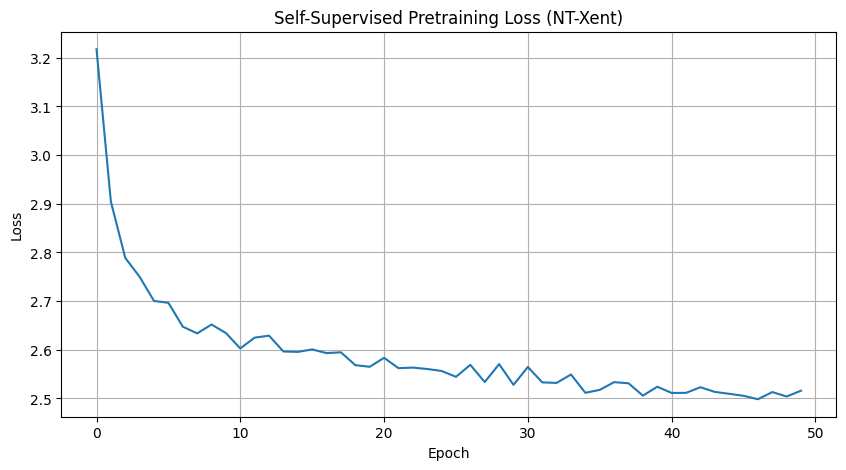

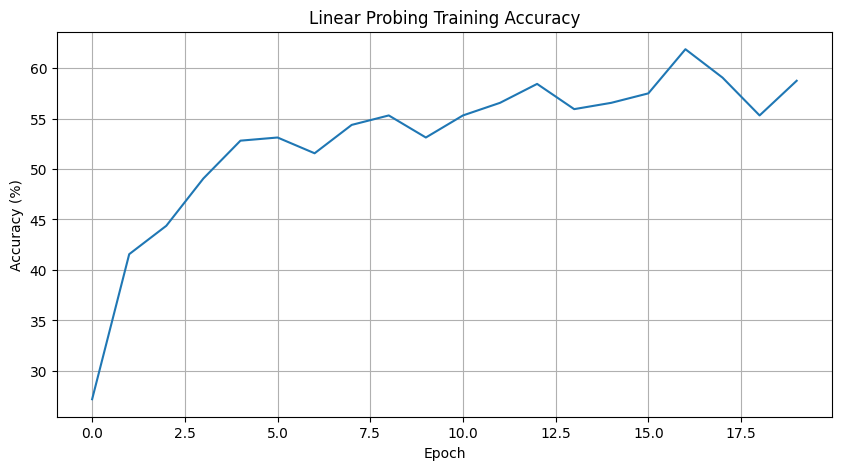

In [12]:
model, classifier, pretrain_losses, train_accs, test_acc = complete_audio_contrastive_pipeline(cfg)

# Plot pretraining losses
plt.figure(figsize=(10, 5))
plt.plot(pretrain_losses)
plt.title('Self-Supervised Pretraining Loss (NT-Xent)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot linear probing training accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs)
plt.title('Linear Probing Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()